# Modules and useful functions

In [137]:
import numpy as np
import scipy.integrate as integrate
import scipy.optimize as opt
import scipy.stats as stats
import matplotlib.pyplot as plt
r = 0.02
chi = 1

un_sur_sqrt_pi = 1/(np.sqrt(2*np.pi))

def gaussian_density(x):
    return un_sur_sqrt_pi*np.exp(-0.5*x**2)

In [138]:
def G(t,T,chi):
    return (1-np.exp(chi*(t-T)))/chi

def A(t,x,y,maturities,bonds,ZC_t,chi,order=0):
    nb_maturities = len(maturities)
    resu = 0
    for n in range(maturities.size-1):
        g = G(t,maturities[n+1],chi)
        resu += (-1)**order * (maturities[n+1]-maturities[n])*(bonds[n+1]/ZC_t)*np.exp(-1*g*x-0.5*y*g**2)*g**order
    return resu

# Swap rate in the model
def S(t,x,y,maturities,bonds,ZC_t,chi):
    if (t==0):
        return (bonds[0]-bonds[-1])/A(t,x,y,maturities,bonds,ZC_t,chi)
    else:
        g0 = G(t,maturities[0],chi)
        gN = G(t,maturities[-1],chi)
        PT0 = bonds[0]*np.exp(-1*g0*x-0.5*y*g0**2)
        PTN = bonds[-1]*np.exp(-1*gN*x-0.5*y*gN**2)
        return (PT0-PTN)/A(t,x,y,maturities,bonds,ZC_t,chi)
    
# dS/dx
def q(t,x,y,maturities,bonds,ZC_t,chi):
    At = A(t,x,y,maturities,bonds,ZC_t,chi)
    B = A(t,x,y,maturities,bonds,ZC_t,chi,1) # A prime
    g0 = G(t,maturities[0],chi)
    gN = G(t,maturities[-1],chi)
    PT0 = (np.exp(-r*(maturities[0]-t))*np.exp(-1*g0*x-0.5*y*g0**2))
    PTN = (np.exp(-r*(maturities[-1]-t))*np.exp(-1*gN*x-0.5*y*gN**2))
    qt = (PTN*gN - PT0*g0)/At - (PT0-PTN)*B/(At**2)
    return qt



# Calibration algorithm

One assume to have a swaption strip of $N-1$ swaptions with a maturity grid $0=T_0,T_1,...,T_N$. The n-th swaption expires at $T_n$ for $n \in [|1,N-1|]$ and the underlying swap pays every 6 months between $T_n$ and $T_N$.
In other words, the n-th underlying swap tenor structure is $(T_n, T_n+6M, ..., T_N)$.

One considers the local volatility under the form $$\sigma_r(t,x,y) = \sum_{n=1}^{N-1} \lambda_n ( S_n(0) + b_n D_n x) \mathbb{1}_{t \in ]T_{n-1},T_n]}, \quad D_n = \frac{\partial S}{\partial x} (t,0,0)$$

So $\bar{y(t)}$ becomes $$\bar{y}(t) = \int_{0}^{t} e^{-2\chi (t-s)} \sigma_r(s,0,0)^2 \ \mathrm{d}s = \frac{1}{2\chi} \sum_{n=1}^{N-1} \lambda_n^2 S_n(0)^2 \big( e^{-2\chi(t-t \land T_n)} - e^{-2\chi(t-t \land T_{n-1})}\big)$$

**Algorithm:**

Let $(\hat{\lambda}_n,\hat{b}_n)_{n=1,N-1}$ a set of observed parameters.

For $n = 1,N-1$:

- Guess a value for $(\lambda_n,b_n)$
- Compute $\bar{x}(t), \bar{y}(t)$ for $t \in [0,T_n]$
- Compute $\bar{\lambda}_{Sn}$ and $\bar{b}_{S_n}$ with the known parameters $(\lambda_i,b_i)_{i=1,n-1}$ and $(\lambda_n,b_n)$
- Find $(\lambda_n,b_n)$ such that $\lVert (\bar{\lambda}_{S_n},\bar{b}_{S_n}) - (\hat{\lambda}_n,\hat{b}_n) \rVert \le \epsilon$ or $(\bar{\lambda}_{S_n} - \hat{\lambda}_n)^2 \le \frac{\epsilon^2}{2} \quad \& \quad (\bar{b}_{S_n} - \hat{b}_n)^2 \le \frac{\epsilon^2}{2}$

In practice, one can directly use a root finding algorithm. Indeed, one notes $$\begin{array}{ll} \psi : \big((\lambda_i)_{i=1,n-1},(b_i)_{i=1,n-1},\lambda,b,T_n \big) \rightarrow \bar{\lambda}_{S_n}\\
\phi : \big((\lambda_i)_{i=1,n-1},(b_i)_{i=1,n-1},\lambda,b,T_n \big) \rightarrow \bar{b}_{S_n} \end{array}$$

One can find the zero of the function $$(\lambda,b) \rightarrow \Big(\psi \big((\lambda_i)_{i=1,n-1},(b_i)_{i=1,n-1},\lambda,b,T_n \big), \phi \big((\lambda_i)_{i=1,n-1},(b_i)_{i=1,n-1},\lambda,b,T_n \big) \Big)- \Big(\hat{\lambda}_n,\hat{b}_n \Big)$$

## 1. Data set

**Set of observed parameters**

In order to construct the set of observed parameters, assume that one has a data set of Black Scholes implied volatility from the market. For a swaption which expires at $T_n$ and strikes values $K_1,...,K_M$, one has the volatility smile $$\hat{\sigma}(T_n,K_m),\quad n=1,N-1 \quad m=1,M$$

One are looking for the parameters $(\hat{\lambda_n},\hat{b}_n)_{n=1,N-1}$ such that the n-th observed swaption price matches a Displaced log-normal swaption price with parameters $(\hat{\lambda}_n,\hat{b}_n)$.

$$\mathrm{d}S_n(t) = \hat{\lambda}_n \big( \hat{b}_n S_n(t) + (1-\hat{b}_n)S_n(0)\big) \ \mathrm{d}W_t$$

One wants $$\forall n, \ (\hat{\lambda_n},\hat{b}_n) = argmin_{(\lambda,b) \in \mathbb{R}\times \mathbb{R}^*} \sum_{m=1}^{M} \Big( Swaption^{LD}(\lambda,b,T_n,K_m) - Swaption^{BS}(T_n,K_m,\hat{\sigma}(T_n,K_m)) \Big)^2$$

A simpler solution is to take for each swaption, $(\hat{\lambda}_n,\hat{b}_n) =$ (IV ATM, IV slope ATM).

In [139]:
#Swaption price under BS model

def Price_BS(S0,A0,T0,K,sigma):
    if(S0*K >0 and S0>0 and sigma>0):
        d = (np.log(S0/K) + 0.5*T0*sigma**2)/(sigma*np.sqrt(T0))
        return S0*A0* stats.norm.cdf(d) -K*A0*stats.norm.cdf(d-sigma*np.sqrt(T0))
    elif (S0*K >0 and S0<0 and sigma>0):
        d = (np.log(S0/K) + 0.5*T0*sigma**2)/(sigma*np.sqrt(T0))
        return S0*A0* stats.norm.cdf(-d) -K*A0*stats.norm.cdf(-d+sigma*np.sqrt(T0))
    else:
        return A0* max(0,S0-K)

#Swaption price under displaced log-normal model

def log_displaced(S0,A0,T0,K,lmbda,b):
    if (S0 == 0 or lmbda==0):
        if ( K < 0):
            return - K * A0
        else:
            return 0
        
    elif (b==0):
        d = (S0-K)/(lmbda*S0*np.sqrt(T0))
        if (S0 * lmbda > 0):
            return A0 * (S0-K) * stats.norm.cdf(d) + A0 * lmbda * S0 * np.sqrt(T0) * gaussian_density(d)
        else:
            return A0 * (S0-K) * stats.norm.cdf(-d) - A0 * lmbda * S0 * np.sqrt(T0) * gaussian_density(d)
        
    elif(S0 -K < S0/b and S0/b < 0):
        return 0
    
    elif (0 < S0/b and S0/b < S0-K):
        return A0 * (S0 - K)
    
    elif (S0/b < 0 and K - S0 + S0/b < 0):
        d = (np.log(S0/(b*K+(1-b)*S0)) + 0.5*lmbda**2 * b**2 * T0)/(lmbda*b*np.sqrt(T0))
        return A0*S0/b * stats.norm.cdf(-d) - A0*(K+(1-b)/b *S0) * stats.norm.cdf(-d + lmbda*b*np.sqrt(T0))
    
    else:
        d = (np.log(S0/(b*K+(1-b)*S0)) + 0.5*lmbda**2 * b**2 * T0)/(lmbda*b*np.sqrt(T0))
        return A0*S0/b * stats.norm.cdf(d) - A0*(K+(1-b)/b *S0) * stats.norm.cdf(d - lmbda*b*np.sqrt(T0))

In [140]:
#test
maturities = np.arange(1,5,1)
bonds = [np.exp(-r*m) for m in maturities]
T0 = 1
strikes = [0.05,0.1,0.15,0.2]
IV = [0.25,0.2,0.18,0.15]
A0 = A(0,0,0,maturities,bonds,1,chi)
S0 = S(0,0,0,maturities,bonds,1,chi)
fun = lambda x: np.array([(log_displaced(S0,A0,T0,strikes[m],x[0],x[1]) - Price_BS(S0,A0,T0,strikes[m],IV[m])) for m in range(len(strikes))])
x_0 = np.array([1,1])
res = opt.least_squares(fun,x_0, bounds=([-np.inf,0], [np.inf,1]))
res

 active_mask: array([0, 0])
        cost: 1.3928831777165984e-11
         fun: array([5.27803596e-06, 7.18771457e-11, 6.37996916e-15, 2.45930228e-18])
        grad: array([1.35050869e-09, 1.38536994e-10])
         jac: array([[2.55873339e-04, 2.62478306e-05],
       [8.29351572e-09, 1.26717228e-09],
       [1.13124882e-12, 1.97198003e-13],
       [5.65487165e-16, 1.05739063e-16]])
     message: '`gtol` termination condition is satisfied.'
        nfev: 7
        njev: 7
  optimality: 1.3505086864831042e-09
      status: 1
     success: True
           x: array([0.29474354, 0.94389479])

In [141]:
#Maturity_grid: set of expiration dates of the swaptions
# Strikes: set of strikes
# IV: Matrix of the observed IV for each T0,K
# returns a numpy array [[lmbda_1,b_1],...,[lmbda_N-1,b_N-1]]

def data_set(maturity_grid,strikes,IV,chi,delta):
    term_date = maturity_grid[-1]
    res = np.zeros((len(maturity_grid)-2,2))
    for i in range(1,len(maturity_grid)-1):
        T = maturity_grid[i]
        maturities = np.arange(T,term_date + delta,delta)
        bonds = [np.exp(-r*m) for m in maturities]
        A0 = A(0,0,0,maturities,bonds,1,chi)
        S0 = S(0,0,0,maturities,bonds,1,chi)
        fun = lambda x: np.array([(log_displaced(S0,A0,T0,strikes[m],x[0],x[1]) - Price_BS(S0,A0,T0,strikes[m],IV[i-1][m])) for m in range(len(strikes))])
        x_0 = np.array([1,1])
        opt_param = opt.least_squares(fun,x_0, bounds=([-np.inf,0], [np.inf,10])).x
        res[i-1] = opt_param
    return res

**Remark:** During the optimization step, we have to ensure that $\ln(\frac{S(0)}{bK+(1-b)S(0)})$ is well defined, so for $0 < K < S(0)$, $b$ has to be bounded by $\frac{S(0)}{S(0)-K}$, so one takes 1 as upper bound to avoid any issue.

In [142]:
#test with a simple data set
maturity_grid = [0,1,2,3]
IV = [[0.25,0.2,0.18,0.15],[0.2,0.18,0.16,0.15],[0.19,0.16,0.12,0.1]]
data_set(maturity_grid,strikes,IV,chi,0.5)

array([[0.30597063, 1.09375421],
       [0.34273686, 1.09376202]])

Observed data set from FinPricing:

| Maturity (M) | Strike    | IV            |  
|--------------|-----------|---------------|
| 1            | 0.01      | 0.528341118   |   
| 1            | 0.02      | 0.208871904   |   
| 1            | 0.03      | 0.315791907   |
| 1            | 0.04      | 0.392419764   |
| 1            | 0.05      | 0.447727552   |
| 1            | 0.07      | 0.524478308   |
| 1            | 0.1       | 0.59765607    |
| 1            | 0.12      | 0.631982811   |


In [143]:
#test with an observed data set
maturity_grid = [0,1/12,1+1/12]
strikes = [0.01,0.02,0.03,0.04,0.05,0.07,0.1,0.12]
IV = [[0.528341118,0.208871904,0.315791907,0.392419764,0.447727552,0.524478308,0.59765607,0.631982811,]]
data = data_set(maturity_grid,strikes,IV,chi,1/12)
print("Observed parameters with least squares method:",data)
print("Observed parameters with basic method:",IV[0][1],(IV[0][0]-IV[0][2])/0.02)


Observed parameters with least squares method: [[0.21607207 4.55800772]]
Observed parameters with basic method: 0.208871904 10.627460550000004


In [144]:
#Compute Implied vol

def biss_python(Mtm, bonds, K, maturities,model = "log-normal",b = 0.5):
    T0 = maturities[0] 
    A0 = A(0,0,0,maturities,bonds,1,chi)
    S0 = S(0,0,0,maturities,bonds,1,chi)
    #Inversion in the log normal model
    if(model == "log-normal"):
        if(Mtm >= S0*A0):
            print("!! Le prix d'entrée est au-dessus des limites BS!!",Mtm, ">", S0*A0)
        if(Mtm < A0*max(0,S0-K)):
            print("!! Le prix d'entrée est en-dessous des limites BS!!", Mtm, "<", A0*max(0,S0-K))
        return opt.bisect(lambda x: round(Price_BS(S0,A0,T0,K,x) - Mtm,16), 0, 50)
    
    #Inversion in the normal model
    if(model == "normal"):
        return opt.bisect(lambda x: swaption_normal(x,K,maturities,bonds) - Mtm, 0, 50) 
    
    #Inversion in the log-displaced model
    if(model == "log-displaced"):
        return opt.bisect(lambda x: log_displaced(x,b,K,maturities,bonds) - Mtm, 0.001,50)

Data set construction with  $$\forall n, \ (\hat{\lambda_n},\hat{b}_n) = argmin_{(\lambda,b) \in \mathbb{R}\times \mathbb{R}^*} \sum_{m=1}^{M} \Big( C_{BS}^{-1}\big(Swaption^{LD}(\lambda,b,T_n,K_m),T_n,K_m\big) - \hat{\sigma}(T_n,K_m) \Big)^2$$

In [145]:
# Observed parameters computed from implied volatility instead of prices

def data_set_bis(maturity_grid,strikes,IV,chi,delta):
    term_date = maturity_grid[-1]
    res = np.zeros((len(maturity_grid)-2,2))
    for i in range(1,len(maturity_grid)-1):
        T = maturity_grid[i]
        maturities = np.arange(T,term_date + delta,delta)
        bonds = [np.exp(-r*m) for m in maturities]
        A0 = A(0,0,0,maturities,bonds,1,chi)
        S0 = S(0,0,0,maturities,bonds,1,chi)
        fun = lambda x: np.array([(biss_python(log_displaced(S0,A0,T0,strikes[m],x[0],x[1]), bonds, strikes[m], maturities) - IV[i-1][m]) for m in range(len(strikes))])
        x_0 = np.array([1,1])
        opt_param = opt.least_squares(fun,x_0, bounds=([-np.inf,0], [np.inf,10])).x
        res[i-1] = opt_param
    return res

In [146]:
data2 = data_set_bis(maturity_grid,strikes,IV,chi,1/12)
data2

array([[0.12536041, 0.98079732]])

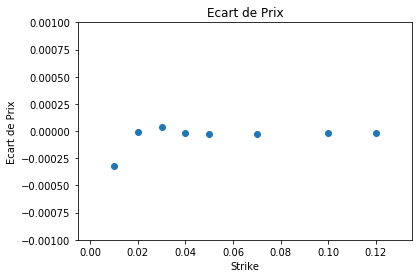

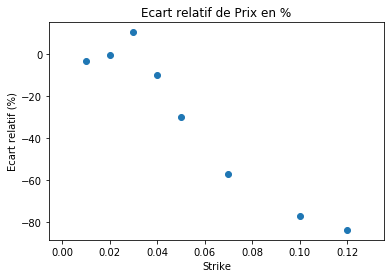

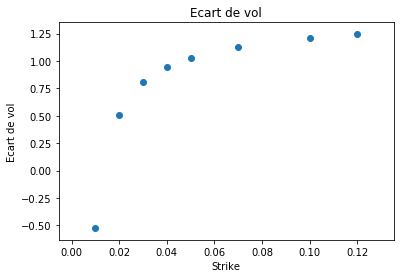

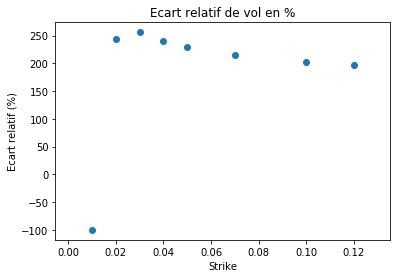

In [147]:
# comparaison des parametres calculés sur les prix et ceux calculés sur la vol. implicite
t = 1/12
maturities = np.arange(t,maturity_grid[-1]+1/12,1/12)
bonds = [np.exp(-r*m) for m in maturities]
A0 = A(0,0,0,maturities,bonds,1,chi)
S0 = S(0,0,0,maturities,bonds,1,chi)
lmbdas = [0]
b_vals = [0]
diff_price1 = [log_displaced(S0,A0,T0,strikes[m],data[0][0],data[0][1]) - Price_BS(S0,A0,T0,strikes[m],IV[0][m]) for m in range(len(strikes))]
diff_vol1 = [(biss_python(log_displaced(S0,A0,T0,strikes[m],data[0][0],data[0][1]), bonds, strikes[m], maturities) - IV[0][m]) for m in range(len(strikes))]

plt.scatter(strikes,diff_price1)
plt.ylim([-0.001, 0.001])
plt.xlabel("Strike")
plt.ylabel("Ecart de Prix")
plt.title("Ecart de Prix")
plt.show()

ecart_relatif = [100*(log_displaced(S0,A0,T0,strikes[m],data[0][0],data[0][1]) - Price_BS(S0,A0,T0,strikes[m],IV[0][m]))/Price_BS(S0,A0,T0,strikes[m],IV[0][m]) for m in range(len(strikes))]
plt.scatter(strikes,ecart_relatif)
plt.xlabel("Strike")
plt.ylabel("Ecart relatif (%)")
plt.title("Ecart relatif de Prix en %")
plt.show()

plt.scatter(strikes,diff_vol1)
#plt.ylim([-0.001, 0.001])
plt.xlabel("Strike")
plt.ylabel("Ecart de vol")
plt.title("Ecart de vol")
plt.show()

ecart_relatif1 = [100*(biss_python(log_displaced(S0,A0,T0,strikes[m],data[0][0],data[0][1]), bonds, strikes[m], maturities) - IV[0][m])/ IV[0][m] for m in range(len(strikes))]
plt.scatter(strikes,ecart_relatif1)
plt.xlabel("Strike")
plt.ylabel("Ecart relatif (%)")
plt.title("Ecart relatif de vol en %")
plt.show()

v = []

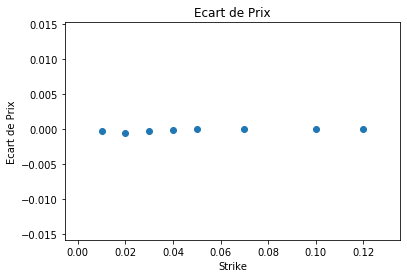

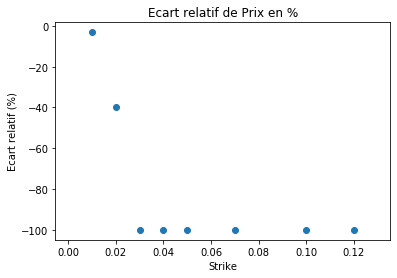

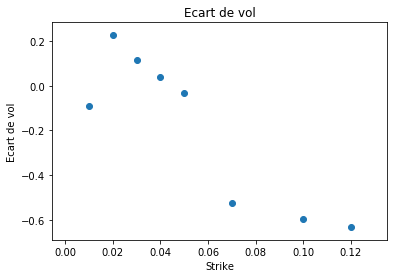

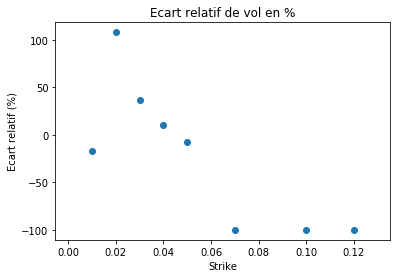

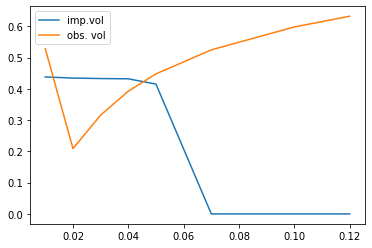

In [149]:
diff_price2 = [log_displaced(S0,A0,T0,strikes[m],data2[0][0],data2[0][1]) - Price_BS(S0,A0,T0,strikes[m],IV[0][m]) for m in range(len(strikes))]
diff_vol2 = [(biss_python(log_displaced(S0,A0,T0,strikes[m],data2[0][0],data2[0][1]), bonds, strikes[m], maturities) - IV[0][m]) for m in range(len(strikes))]

plt.scatter(strikes,diff_price2)
#plt.ylim([-0.001, 0.001])
plt.xlabel("Strike")
plt.ylabel("Ecart de Prix")
plt.title("Ecart de Prix")
plt.show()

ecart_relatif2 = [100*(log_displaced(S0,A0,T0,strikes[m],data2[0][0],data2[0][1]) - Price_BS(S0,A0,T0,strikes[m],IV[0][m]))/Price_BS(S0,A0,T0,strikes[m],IV[0][m]) for m in range(len(strikes))]
plt.scatter(strikes,ecart_relatif2)
plt.xlabel("Strike")
plt.ylabel("Ecart relatif (%)")
plt.title("Ecart relatif de Prix en %")
plt.show()

plt.scatter(strikes,diff_vol2)
plt.xlabel("Strike")
plt.ylabel("Ecart de vol")
plt.title("Ecart de vol")
plt.show()

ecart_relatif3 = [100*(biss_python(log_displaced(S0,A0,T0,strikes[m],data2[0][0],data2[0][1]), bonds, strikes[m], maturities) - IV[0][m])/ IV[0][m] for m in range(len(strikes))]
plt.scatter(strikes,ecart_relatif3)
plt.xlabel("Strike")
plt.ylabel("Ecart relatif (%)")
plt.title("Ecart relatif de vol en %")
plt.show()

v= [biss_python(log_displaced(S0,A0,T0,strikes[m],data2[0][0],data2[0][1]), bonds, strikes[m], maturities) for m in range(len(strikes))]
u = IV[0]
plt.plot(strikes,v,label= 'imp.vol')
plt.plot(strikes,u,label='obs. vol')
plt.legend()
plt.show()

[0.19998211 1.05439538]


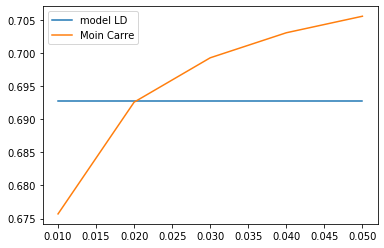

In [174]:
strikes = [0.01,0.02,0.03,0.04,0.05]
Prices = [log_displaced(S0,A0,T0,k,0.2,1) for k in strikes]
fun = lambda x: np.array([log_displaced(S0,A0,T0,strikes[m],x[0],x[1]) - Prices[m] for m in range(len(strikes))])
x_0 = np.array([0.4,1])
opt_param = opt.least_squares(fun,x_0, bounds=([-np.inf,0], [np.inf,11])).x
print(opt_param)

plt.plot(strikes,[biss_python(log_displaced(S0,A0,T0,strikes[m],0.2,1), bonds, strikes[m], maturities) for m in range(len(strikes))],label='model LD')
plt.plot(strikes,[biss_python(log_displaced(S0,A0,T0,strikes[m],opt_param[0],opt_param[1]), bonds, strikes[m], maturities) for m in range(len(strikes))],label='Moin Carre')
plt.legend()
plt.show()

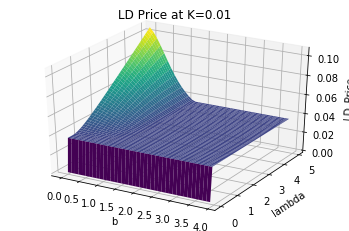

In [135]:
from mpl_toolkits.mplot3d import Axes3D
x_vals = np.arange(0,5,0.1)
y_vals = np.arange(0,4,0.1)
X,Y = np.meshgrid(y_vals,x_vals)
Z = np.zeros((len(x_vals),len(y_vals)))
for i in range(len(x_vals)):
    for j in range(len(y_vals)):
        Z[i][j] = log_displaced(S0,A0,T0,strikes[0],x_vals[i],y_vals[j])

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
ax.set_xlabel('b')
ax.set_ylabel('lambda')
ax.set_zlabel('LD_Price')
plt.title("LD Price at K=0.01")
plt.show()

## 2.  $\bar{x}, \ \bar{y}$

In [111]:
#maturity_grid : (T0=0,...,TN) n-th swaption of the strip expires at Tn
#lmbdas : [lambda_1,...,lambda_n-1] known values of lambda 
# l : parameter for lambda_n
def y0(t,lmbdas,l,chi,maturity_grid):
    term_date = maturity_grid[-1]
    strip_size = np.size(maturity_grid)
    resu = 0
    i = 0
    while (t > maturity_grid[i]):
        Tn_m1 = maturity_grid[i]
        Tn = maturity_grid[i+1]
        mat = np.arange(Tn,term_date+0.5,0.5)
        S0 = S(0,0,0,mat,[np.exp(-r*m) for m in mat],1,chi)
        if (Tn >= t):
            resu += l**2 * S0**2 * (np.exp(-2*chi*(t-min(t,Tn))) - np.exp(-2*chi*(t-Tn_m1)))
        else:
            resu+= lmbdas[i]**2 * S0**2 * (np.exp(-2*chi*(t-Tn)) - np.exp(-2*chi*(t-Tn_m1)))
        i += 1 
    
    return resu/(2*chi)

In [112]:
y0(1.4,[0.5],1,chi,np.array([0,1,2,3]))

0.0008302931375863749

In [113]:
#First order approximation x0(t) 

def x0(t,maturities,bonds,lmbdas,l,chi,maturity_grid):
    S0 = S(0,0,0,maturities,bonds,1,chi)                
    g0 = G(t,maturities[0],chi)
    gN = G(t,maturities[-1],chi)
    y = y0(t,lmbdas,l,chi,maturity_grid)
    Swap_rate = lambda x: S(t,x,y,maturities,bonds,np.exp(-r*t),chi) - S0
    dS = lambda x: q(t,x,y,maturities,bonds,np.exp(-r*t),chi)
    return opt.newton(Swap_rate,0,dS)  #Newton method
    #return opt.newton(Swap_rate,0) # secant method 

In order to compute the second order approximation of $\mathbb{E}^A\big[x(t)\big]$, one needs to compute the value of $$\int_{0}^{t} \frac{\partial S}{\partial x}(s,0,0)^2 \sigma_r(s,0,0)^2 \ \mathrm{d}s = \sum_{n=1}^{N-1} \lambda_n^2 S_n(0)^2 \int_{T_{n-1}\land t}^{T_n \land t} \frac{\partial S}{\partial x}(s,0,0)^2 \ \mathrm{d}s$$

In [114]:
 #second derivative d2S/dx2
def dS2(t,x,y,maturities,bonds,ZC_t,chi):
    g0 = G(t,maturities[0],chi)
    gN = G(t,maturities[-1],chi)
    PT0 = (np.exp(-r*(maturities[0]-t))*np.exp(-1*g0*x-0.5*y*g0**2))
    PTN = (np.exp(-r*(maturities[-1]-t))*np.exp(-1*gN*x-0.5*y*gN**2))
    At = A(t,x,y,maturities,bonds,ZC_t,chi)
    Aprime = A(t,x,y,maturities,bonds,ZC_t,chi,1)
    Apprime = A(t,x,y,maturities,bonds,ZC_t,chi,2)
    S_rate = S(t,x,y,maturities,bonds,ZC_t,chi)
    return (g0**2 * PT0 - gN**2 * PTN - S_rate * Apprime)/At + 2*Aprime * (Aprime*S_rate + g0*PT0 - gN*PTN)/(At**2)

#second order approximation
def x_bar(t,maturities,bonds,ZC_t,lmbdas,l,chi,maturity_grid):
    y = y0(t,lmbdas,l,chi,maturity_grid)
    x = x0(t,maturities,bonds,lmbdas,l,chi,maturity_grid)
    #second derivative d2S/dx2
    d2S = dS2(t,x,y,maturities,bonds,ZC_t,chi)
    #second derivative d2X/ds2
    dX2 = -1*d2S/(q(t,x,y,maturities,bonds,ZC_t,chi)**3)
    #Compute Var
    term_date = maturity_grid[-1]
    strip_size = np.size(maturity_grid)
    i = 0
    Var = 0
    while (t > maturity_grid[i]) & (i < strip_size-2):
        Tn_m1 = maturity_grid[i]
        Tn = maturity_grid[i+1]
        mat = np.arange(Tn,term_date+0.5,0.5)
        S0 = S(0,0,0,mat,[np.exp(-r*m) for m in mat],1,chi)
        if (i == strip_size-3):
            Var += l**2 * S0**2 * integrate.quad(lambda s:  q(s,0,0,maturities,bonds,np.exp(-r*s),chi)**2,Tn_m1,min(t,Tn))[0]
        else:
            Var += lmbdas[i]**2 * S0**2 * integrate.quad(lambda s:  q(s,0,0,maturities,bonds,np.exp(-r*s),chi)**2,Tn_m1,min(t,Tn))[0]
        i += 1 
    return x + 0.5 * dX2 * Var

In [115]:
#test
t = 1.5
lmbdas = [0.5]
l = 1
maturity_grid = [0,1,2,3]
y = y0(t,lmbdas,l,chi,maturity_grid)
maturities = np.arange(t,t+5.5,0.5)
bonds = [np.exp(-r*m) for m in maturities]
S0 = S(0,0,0,maturities,bonds,1,chi)
x = x0(t,maturities,bonds,lmbdas,l,chi,maturity_grid)
print("x0= ",x,"S0= ",S0,"S(t,x0,y_bar)= ",S(t,x,y,maturities,bonds,np.exp(-r*t),chi))

x0=  0.017423630645954605 S0=  0.05063024104885767 S(t,x0,y_bar)=  0.05063024101502923


In [116]:
x_bar(t,maturities,bonds,np.exp(-r*t),lmbdas,l,chi,maturity_grid)

0.01711784451554395

## 3. $\bar{\lambda_{S_n}}, \bar{b_{S_n}}$

In [117]:
#function t -> lambda_S  in the pricing formula
def lS(t,x,y,lmbda,b,chi,maturities,bonds,ZC_t):
    S0 = S(0,0,0,maturities,bonds,1,chi)
    dS = q(t,x,y,maturities,bonds,ZC_t,chi)
    return (lmbda/S0) * dS * (S0 + b * x)

#function t -> b_S  in the pricing formula
def bS(t,x,y,b,chi,maturities,bonds,ZC_t):
    S0 = S(0,0,0,maturities,bonds,1,chi)
    dS = q(t,x,y,maturities,bonds,ZC_t,chi)
    d2S = dS2(t,x,y,maturities,bonds,ZC_t,chi)
    return (S0 * b) / ((S0 + b * x) * dS) + S0 * d2S/(dS**2)

In [118]:
# f: t -> int_0^t lambda_Sn (s)^2 ds

def f(t,maturities, bonds, maturity_grid,lmbdas, b_vals, l, b, chi):
    i = 0
    resu = 0
    while (maturity_grid[i] < t):
        #last integral with unknown parameters l,b
        if(maturity_grid[i+1] >= t):
            resu += integrate.quad(lambda u: lS(u,x_bar(u,maturities,bonds,np.exp(-r*u),lmbdas,l,chi,maturity_grid),y0(u,lmbdas,l,chi,maturity_grid),l,b,chi,maturities,bonds,np.exp(-r*u))**2 ,maturity_grid[i],t)[0]
        #integrals with known parameters lambda_i, b_i
        else:
            resu += integrate.quad(lambda u: lS(u,x_bar(u,maturities,bonds,np.exp(-r*u),lmbdas,l,chi,maturity_grid),y0(u,lmbdas,l,chi,maturity_grid),lmbdas[i],b_vals[i],chi,maturities,bonds,np.exp(-r*u))**2 ,maturity_grid[i],maturity_grid[i+1])[0]
        i += 1
    return resu


#maturities: payments dates of the underlying swap [Tn,...,TN]
def lambda_bar(maturities, bonds, maturity_grid,lmbdas, b_vals, l, b, chi):
    Tn = maturities[0]
    I = f(Tn,maturities, bonds, maturity_grid,lmbdas, b_vals, l, b, chi)
    return np.sqrt(I/Tn)

In [119]:
#
#index : index to use the value of lambda, b on the right interval
def phi(u,index,maturities,bonds,maturity_grid,lmbdas,b_vals,l,b,chi):
    y = y0(u,lmbdas,l,chi,maturity_grid)
    x = x_bar(u,maturities,bonds,np.exp(-r*u),lmbdas,l,chi,maturity_grid)
    if (index == -1):
        return bS(u,x,y,b,chi,maturities,bonds,np.exp(-r*u)) * lS(u,x,y,l,b,chi,maturities,bonds,np.exp(-r*u))**2 * f(u,maturities,bonds,maturity_grid,lmbdas,b_vals,l,b,chi)
    else:
        return bS(u,x,y,b_vals[index],chi,maturities,bonds,np.exp(-r*u)) * lS(u,x,y,lmbdas[index],b_vals[index],chi,maturities,bonds,np.exp(-r*u))**2 * f(u,maturities,bonds,maturity_grid,lmbdas,b_vals,l,b,chi)

def b_bar(maturities, bonds, maturity_grid, lmbdas, b_vals, l, b, chi):
    Tn = maturities[0]
    i = 0
    I = 0
    Denom = 0
    while(maturity_grid[i] < Tn):
        #Last integral with unknown parameters l,b
        if(maturity_grid[i+1] == Tn):
            I += integrate.quad(lambda u: phi(u,-1,maturities,bonds,maturity_grid,lmbdas,b_vals,l,b,chi),maturity_grid[i],Tn)[0]
            Denom += integrate.quad(lambda u: lS(u,x_bar(u,maturities,bonds,np.exp(-r*u),lmbdas,l,chi,maturity_grid),y0(u,lmbdas,l,chi,maturity_grid),l,b,chi,maturities,bonds,np.exp(-r*u))**2 * f(u,maturities,bonds,maturity_grid,lmbdas,b_vals,l,b,chi),maturity_grid[i],Tn)[0]
        
        #integrals with known parameters lambda_i,b_i
        else:
            I += integrate.quad(lambda u: phi(u,i,maturities,bonds,maturity_grid,lmbdas,b_vals,lmbdas[i],b_vals[i],chi),maturity_grid[i],maturity_grid[i+1])[0]
            Denom += integrate.quad(lambda u: lS(u,x_bar(u,maturities,bonds,np.exp(-r*u),lmbdas,l,chi,maturity_grid),y0(u,lmbdas,l,chi,maturity_grid),lmbdas[i],b_vals[i],chi,maturities,bonds,np.exp(-r*u))**2 * f(u,maturities,bonds,maturity_grid,lmbdas,b_vals,l,b,chi),maturity_grid[i],maturity_grid[i+1])[0]
        i += 1
    
    return I / Denom

## Tests

In [126]:
t = 1/12
maturity_grid = [0,1/12,1]
maturities = np.arange(t,1 + 1/12, 1/12)
bonds = [np.exp(-r*m) for m in maturities]
lmbdas = [0]
b_vals = [0]
f(t,maturities, bonds, maturity_grid,lmbdas, b_vals, 0.5, 1, chi)

0.008404287088767521

In [127]:
lambda_bar(maturities, bonds, maturity_grid,lmbdas, b_vals, 1, 1, chi)

0.6347593760987931

In [128]:
phi(t,-1,maturities,bonds,maturity_grid,lmbdas,b_vals,0.5,0.1,chi)

0.00014789288374610754

In [129]:
b_bar(maturities, bonds, maturity_grid, lmbdas, b_vals, 1, 0.1, chi)

0.1666093772614822

## 4. Calibration

The main difficulty in the calibration code is the method with which one computes the values of
$(\lambda_n,b_n)$ by making $\bar{\lambda_{S_n}},\bar{b_{S_n}}$ match with $\hat{\lambda_n},\hat{b_n}$. 
Indeed, on $]T_{n-1},T_n]$, $\bar{\lambda_{S_n}}$ and $\bar{b_{S_n}}$ depend on $\lambda_n$ and $b_n$, that's why one can't use a simple root finding. There exists a Newton algorithm in dimension 2, but it requires a Jacobian matrix and we haven't explicit formula for the derivatives with respect to $\lambda,b$ here.

One solution is to divide the problem in two parts. 
- On the one hand, one computes the value of $\lambda_n$ by approximating $\bar{x}(t) \approx 0$ on $]T_{n-1},T_n]$ in order to get an expression of $\bar{\lambda_{S_n}}$ independent of $b_n$.
$$\begin{array}{ll} 
\bar{\lambda_{S_n}} &= \Big( \frac{1}{T_n} \int_{0}^{T_n} \lambda_{S_n}(t)^2 \ \mathrm{d}t \Big)^{\frac{1}{2}} \\
&= \Big( \frac{1}{T_n} \big( \int_{0}^{T_{n-1}} \lambda_{S_n}(t)^2 \ \mathrm{d}t + \int_{T_{n-1}}^{T_n} \lambda_{S_n}(t, \lambda_n,b_n,\bar{x}(t))^2 \ \mathrm{d}t\big) \Big)^{\frac{1}{2}} \\
&\approx \Big( \frac{1}{T_n} \big( \int_{0}^{T_{n-1}} \lambda_{S_n}(t)^2 \ \mathrm{d}t + \int_{T_{n-1}}^{T_n} \lambda_{S_n}(t, \lambda_n,b_n,0)^2 \ \mathrm{d}t\big) \Big)^{\frac{1}{2}} \\
&= \big( Z_1 ((\lambda_i)_{i=1,n-1},(b_i)_{i=1,n-1}) + \zeta_1(\lambda_n) \big)^{\frac{1}{2}}
\end{array}$$

- On the other hand 
$$\begin{array}{ll} 
\bar{b_{S_n}} &= \int_{0}^{T_n} b_{S_n}(t) \ w_{S_n}(t) \ \mathrm{d}t \\
&= \int_{0}^{T_{n-1}} b_{S_n}(t) w_{S_n}(t) \ \mathrm{d}t + \int_{T_{n-1}}^{T_n} b_{S_n}(t) \ w_{S_n}(t,\lambda_n,b_n) \ \mathrm{d}t \\
&= Z_2 ((\lambda_i)_{i=1,n-1},(b_i)_{i=1,n-1}) + \zeta_2(\lambda_n,b_n)
\end{array}$$
And one solves this equation for $b_n$, using the computed value of $\lambda_n$ from last step.

In [132]:
# Calibration algorithm

def calib(data, maturity_grid, delta):
    N = len(maturity_grid) - 1
    term_date = maturity_grid[-1]
    lmbdas = np.zeros(N-1)
    b_vals = np.zeros(N-1)
    for n in range(0,N-1):
        maturities = np.arange(maturity_grid[n+1],term_date + delta, delta)
        bonds = [np.exp(-r*m) for m in maturities]
        
        #Root finding for lambda_n
        lambda_obs = data[n][0]
        lambda_n = opt.bisect(lambda l: lambda_bar(maturities, bonds, maturity_grid,lmbdas, b_vals, l, 0, chi) - lambda_obs,0,10)
        lmbdas[n] = lambda_n
        
        #Root finding for b_n
        b_obs = data[n][1]
        b_n = opt.bisect(lambda b: b_bar(maturities, bonds, maturity_grid, lmbdas, b_vals, lambda_n, b, chi) - b_obs, 0 , 5)
        b_vals[n] = b_n
    return lmbdas,b_vals

In [133]:
maturity_grid = [0,1/12,1]
strikes = [0.01,0.02,0.03,0.04,0.05,0.07,0.1,0.12]
IV = [[0.528341118,0.248871904,0.315791907,0.392419764,0.447727552,0.524478308,0.59765607,0.631982811]]
data = data_set(maturity_grid,strikes,IV,chi,1/12)
calib(data, maturity_grid, 1/12)

(array([0.74128938]), array([1.37870975]))